<a href="https://colab.research.google.com/github/amosdisabatino/Rete-Neurale-Per-Guida-Autonoma/blob/main/Rete_Neurale_Per_Guida_Autonoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,\
  Dropout, BatchNormalization
from tensorflow.keras.models import load_model, Sequential
import warnings

In [ ]:
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

 # Importing "CIFAR10" Dataset

In [ ]:
cifar10 = tf.keras.datasets.cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Preprocessing the Data

To implement the neural network, I use the Image Dataset “CIFAR10”, each image is 32*32 in size and is set to the three RGB color channels, the dataset consists of 10000 images in total.

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# NOTE: the order of the labels is defined by the official documentation of the
# dataset.
labels = ['airplane','automobile','bird','cat','deer','dog',\
          'frog','horse','ship','truck']

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


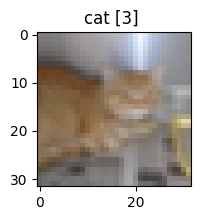

In [ ]:
plt.figure(figsize=(2,2))
indx = np.random.choice(range(50000))
plt.imshow(x_train[indx])
plt.title(f"{labels[y_train[indx][0]]} {y_train[indx]} ");

## Dividing the dataset into two macro categories

The purpose of the neural network is for it to be able to distinguish animals from vehicles, so I have to label the various images into two macro-categories: Vehicle or Animal.

Here it can be seen that the original training and test data are divided according to the original 10 labels.

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

After using the "relabelling" method to label the data into two macro categories, it can be seen that the data actually are divided into: "Animals" (value 0) and "Vehicles" (value 1).

In [ ]:
animal_categories = [2, 3, 4, 5, 6, 7]
vehicle_categories = [0, 1, 8, 9]

def relabeling(y_data_set):
    y_new = []
    for y_istance in y_data_set:
        if y_istance[0] in animal_categories:
            y_new.append(0)  # Animal
        elif y_istance[0] in vehicle_categories:
            y_new.append(1)  # Vehicle
        else:
            y_new.append(2)  # Not recognized
    return np.array(y_new)

new_y_train = relabeling(y_train)
new_y_test = relabeling(y_test)

It can be seen that after data labeling, there is more data on the category "Animals" than the category "Vehicles". The data set is a little unbalanced.

In [ ]:
np.unique(new_y_train, return_counts=True)

(array([0, 1]), array([30000, 20000]))

In [ ]:
np.unique(new_y_test, return_counts=True)

(array([0, 1]), array([6000, 4000]))

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0
new_y_train, new_y_test = new_y_train.flatten(), new_y_test.flatten()

# Implementing The Model

In order to implement the neural network and minimize the loss, I decided to use the regularization technique of 'Early Stopping', so as to prevent overfitting and stop the training phase at the moment when the `validation_loss` no longer seems to go down and restore the best weights of the network.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
)

The neural network is composed as follows:

  - In the first convolution layer I apply 32 filters to extract 32 basic features from the images through the use of a 3*3 matrix sliding over the images, the relu-type activation function makes the model nonlinear and get only the most important features.
  BatchNormalization normalizes the data after each convolution to speed up the training, because the values within the network may become too large or too small.
  MaxPooling2D, reduces the height and width of the feture map keeping only the most important information;

  - In the other two convolutional layers I apply twice as many filters as in the previous layers (32 -> 64 ->128) to extract more features from the images;

  - The flatten layer transforms the 3D tensor into a 1D vector;

  - The two fully connected "Dense" layers are used to combine the features and patterns in the 1D vector and determine the final result: whether the input image is an animal or a vehicle, gradually reducing the number of neurons (from 128 to 64) helps prevent the neural network from becoming too complex so avoid overfitting.
  Same with 'dropout' that randomly shuts down a proportion of neurons to improve generalization ability;

  - The output layer consists of only one neuron because it has to classify only two classes, the "sigmoid" activation function returns a value from 0 to 1, if it is close to 0, the image is classified as an animal otherwise it is classified as a vehicle.

In [ ]:
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

In [ ]:
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 364,737 (1.39 MB)

 Trainable params: 364,289 (1.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
hist1 = cnn.fit(
    x_train,
    new_y_train,
    validation_data=(x_test, new_y_test),
    epochs=50,
    callbacks=[early_stopping],
)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 178s 111ms/step - accuracy: 0.8380 - loss: 0.4131 - val_accuracy: 0.9118 - val_loss: 0.2308
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 199s 109ms/step - accuracy: 0.9159 - loss: 0.2224 - val_accuracy: 0.9099 - val_loss: 0.2108
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 204s 111ms/step - accuracy: 0.9318 - loss: 0.1870 - val_accuracy: 0.8053 - val_loss: 0.4941
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 200s 110ms/step - accuracy: 0.9399 - loss: 0.1624 - val_accuracy: 0.9028 - val_loss: 0.2214
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 203s 110ms/step - accuracy: 0.9455 - loss: 0.1409 - val_accuracy: 0.9131 - val_loss: 0.2283


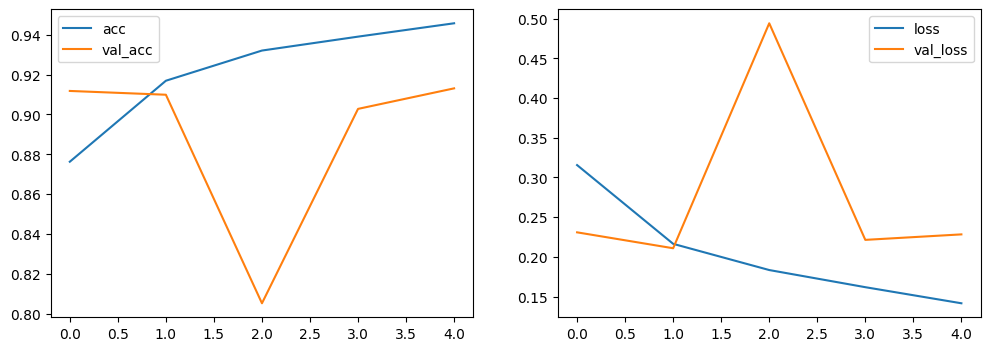

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist1.history['accuracy'], label='acc')
plt.plot(hist1.history['val_accuracy'], label='val_acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist1.history['loss'], label='loss')
plt.plot(hist1.history['val_loss'], label='val_loss')
plt.legend();

During model training, I apply the "early stopping" method to prevent overfitting and ensure good generalization to new data. From graph analysis, it is observed that accuracy and validation accuracy increase in the first epochs, while loss and validation loss decrease. However, at the third epoch, validation loss shows a peak and validation accuracy has a temporary drop, signaling potential fluctuations in the learning process. Training stops at the fifth epoch as validation accuracy stops improving, meeting the early stopping criterion.

In [ ]:
cnn.evaluate(x_test, new_y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9118 - loss: 0.2109


[0.2108108401298523, 0.9099000096321106]

The model gets an accuracy of 91% with the test data, there seems to be no problem of "overfitting".

# Analysis Of The Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


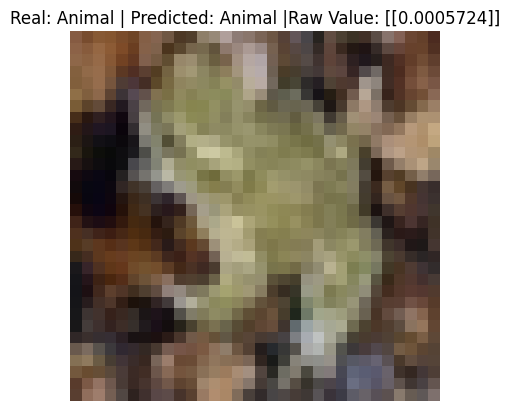

In [ ]:
index = np.random.randint(0, len(x_test))
img = x_test[index]
label_reale = new_y_test[index]

img_input = np.expand_dims(img, axis=0)

prediction = cnn.predict(img_input)
pred_label = (prediction > 0.5).astype(int)

label_map = {0: "Animal", 1: "Vehicle"}

plt.imshow(img)
plt.title(
    f"Real: {label_map[label_reale]} | "
    f"Predicted: {label_map[pred_label[0][0]]} |"
    f"Raw Value: {prediction}"

)
plt.axis("off")
plt.show()

In [ ]:
y_pred = cnn.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
print(
    classification_report(
        new_y_test, y_pred, target_names=['Animal', 'Vehicle']
    )
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
              precision    recall  f1-score   support

      Animal       0.88      0.98      0.93      6000
     Vehicle       0.97      0.80      0.88      4000

    accuracy                           0.91     10000
   macro avg       0.92      0.89      0.90     10000
weighted avg       0.92      0.91      0.91     10000



Analyzing the classification report of the test data, it can be seen that for both classes there are good values of: Precision, Recall and F1-Score.
For the category "Vehicle" the value of F1-Score is lower, this could be due to the fact that, in the dataset, there are fewer vehicle images than animal images.

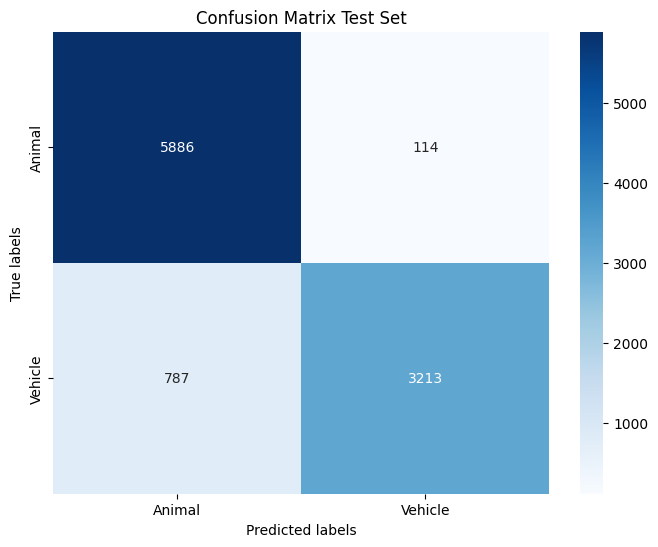

In [ ]:
cm = confusion_matrix(new_y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, cmap='Blues', fmt='d',
    xticklabels=['Animal', 'Vehicle'],
    yticklabels=['Animal', 'Vehicle'],
)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Test Set')
plt.show()

The confusion matrix also shows that the neural network is able to classify images of animals more accurately than images of vehicles: in fact, more images of vehicles are misclassified as animals.